**Setting Up Google Colab and Mounting Google Drive**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extracting .rar Files in Colab**

1.   Install the unrar tool to handle .rar files in Colab.
2.   Extract the dataset. Move your .rar files to your Google Drive and specify the file path to extract them. Replace "your_dataset.rar" with the actual filename in your Drive.

This will extract the files into a directory named /content/dataset/. Now, you should have subfolders like COVID-19, Pneumonia, and Normal, depending on the dataset structure.



In [3]:
# Install unrar to handle .rar files
!apt-get install unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


**Flatten the Directory Structure After Extraction**

We’ll modify the extraction process to automatically move images from the nested folders to a single-level structure. Here’s how you can do it:

In [4]:
import os
import shutil

# Paths to the .rar files
covid_rar = '/content/drive/MyDrive/PROJECT_HDA/data/covid.rar'
normal_rar = '/content/drive/MyDrive/PROJECT_HDA/data/normal.rar'
pneumonia_rar = '/content/drive/MyDrive/PROJECT_HDA/data/pneumonia.rar'

# Define the target directories for each class
target_dirs = {
    'covid': '/content/dataset/covid',
    'normal': '/content/dataset/normal',
    'pneumonia': '/content/dataset/pneumonia'
}

# Ensure target directories exist
for dir_path in target_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# Step 1: Extract each .rar file into a temporary directory
temp_extract_dir = '/content/temp_extract/'  # Temporary directory for nested extraction
os.makedirs(temp_extract_dir, exist_ok=True)

# Extract and flatten each .rar file
!unrar x {covid_rar} {temp_extract_dir}
!unrar x {normal_rar} {temp_extract_dir}
!unrar x {pneumonia_rar} {temp_extract_dir}

# Step 2: Move images from nested folders to the correct target directories
for cls, target_dir in target_dirs.items():
    cls_temp_dir = os.path.join(temp_extract_dir, cls)  # Navigate to nested directory

    # Walk through all subdirectories and find image files
    for root, _, files in os.walk(cls_temp_dir):
        for file in files:
            # Only move image files (e.g., .jpg, .jpeg, .png)
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Move each image to the target directory for its class
                shutil.move(os.path.join(root, file), os.path.join(target_dir, file))

print("Extraction and directory flattening complete.")



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/PROJECT_HDA/data/covid.rar

Creating    /content/temp_extract/covid                               OK
Extracting  /content/temp_extract/covid/01E392EE-69F9-4E33-BFCE-E5C968654078-768x572.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C-1068x1083.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/0C7E78DA-FAFC-480D-88B6-1459C51481AF-1068x817.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/1312A392-67A3-4EBF-9319-810CF6DA5EF6-1068x1086.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/134895D3-77B8-4546-B7E5-C7DABD600309-1068x911.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D-768x635.jpeg       0%  OK 
Extracting  /content/temp_extract/covid/1F6343EE-AFEC-4B7D-97F5-62797EE18767-1068x1064.jpeg     

In [5]:
import os

# List the extracted files in each folder
print("COVID files:", os.listdir('/content/dataset/covid')[:5])  # Show first 5 files
print("Normal files:", os.listdir('/content/dataset/normal')[:5])
print("Pneumonia files:", os.listdir('/content/dataset/pneumonia')[:5])


COVID files: ['COVID-19 (390).jpg', 'COVID-19 (451).jpg', 'COVID-19 (624).jpg', 'COVID19(165).jpg', 'COVID-19 (704).jpg']
Normal files: ['00000840_000.png', '00000947_001.png', '00000652_008.png', '00000393_000.png', '00000054_008.png']
Pneumonia files: ['person1261_virus_2148.jpeg', 'person357_bacteria_1639.jpeg', 'person276_bacteria_1298.jpeg', 'person1865_bacteria_4737.jpeg', 'person1349_bacteria_3437.jpeg']


**Environment Setup and Dataset Preparation**

Set up the basic imports for model building, data loading, and visualization.

In [6]:
#required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

**Create Train/Test Split**

We’ll create a train and test split programmatically:

Set up separate train and test folders, create a structure for the train and test sets, with 80% of the images in train and 20% in test.

Copy a portion of images from each class folder into the new train and test folders.We’ll use shutil to copy files into new directories.

After running this code, your directory structure should look like this:

/content/dataset_split/

├── train/
│   ├── covid/
│   ├── normal/
│   └── pneumonia/

└── test/
    ├── covid/
    ├── normal/
    └── pneumonia/

In [7]:
import os
import random
import shutil

# # Define paths for the train and test split
data_dir = "/content/dataset"
train_dir = "/content/dataset_split/train"
test_dir = "/content/dataset_split/test"

# Define the class names
classes = ['covid', 'normal', 'pneumonia']

# Define the split ratio
train_ratio = 0.8

# Create train and test directories for each class/ Loop over each class folder to split images
for cls in classes:
# Create the class directories in train and test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Source folder for each class
    cls_folder = os.path.join(data_dir, cls)
#    cls_folder = f"/content/dataset/{cls}"
    print(f"Contents of {cls_folder}:")
    print(os.listdir(cls_folder))

    # Get list of images in each class folder
    images = [img for img in os.listdir(cls_folder) if os.path.isfile(os.path.join(cls_folder, img))]

    # Shuffle images and split based on train_ratio
    random.shuffle(images)
    split_idx = int(len(images) * train_ratio)
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Copy images to the respective train and test directories
    for img in train_images:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(train_dir, cls, img))
    for img in test_images:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(test_dir, cls, img))

print("Dataset split and organization complete.")

Contents of /content/dataset/covid:
['COVID-19 (390).jpg', 'COVID-19 (451).jpg', 'COVID-19 (624).jpg', 'COVID19(165).jpg', 'COVID-19 (704).jpg', 'COVID19(396).jpg', 'COVID-19 (407).jpg', 'COVID-19 (90).jpg', 'COVID-19 (343).jpg', 'COVID-19 (806).jpg', 'COVID-19 (274).jpg', 'COVID19(203).jpg', 'COVID-19 (113).jpg', 'COVID19(398).jpg', 'COVID19(271).jpg', 'COVID-19 (22).jpeg', 'COVID-19 (483).jpg', 'COVID19(76).jpg', 'COVID-19 (458).jpg', 'COVID-19 (277).jpg', 'COVID-19 (841).jpg', 'COVID-19 (584).jpg', 'COVID19(312).jpg', 'COVID19(178).jpg', 'COVID19(307).jpg', 'COVID-19 (506).jpg', 'COVID19(531).jpg', 'COVID-19 (774).jpg', 'COVID19(542).jpg', 'COVID-19 (233).jpg', 'COVID-19 (317).jpg', 'COVID19(373).jpg', 'COVID-19 (1).jpg', 'COVID19(453).jpg', 'COVID-19 (249).jpg', 'COVID19(162).jpg', 'COVID-19 (513).jpg', 'COVID-19 (44).jpg', 'COVID-19 (718).jpg', 'COVID-19 (644).jpg', 'COVID19(314).jpg', '7AF6C1AF-D249-4BD2-8C26-449304105D03-1068x881.jpeg', 'COVID19(156).jpg', 'COVID19(196).jpg', 'C

**Verify Image Paths and Formats**

Check if the images were copied correctly into the /content/dataset_split/train and /content/dataset_split/test folders.

In [8]:
import os

# Check if images are correctly copied and have valid formats
train_dir = "/content/dataset_split/train"
test_dir = "/content/dataset_split/test"
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# Function to list files in a directory and check extensions
def check_images(directory):
    for cls in os.listdir(directory):
        class_dir = os.path.join(directory, cls)
        if os.path.isdir(class_dir):
            print(f"Checking '{cls}' class in '{directory}':")
            images = [f for f in os.listdir(class_dir) if os.path.splitext(f)[1].lower() in valid_extensions]
            print(f"  Found {len(images)} valid images.")
            if len(images) == 0:
                print("  Warning: No valid images found in this class folder!")

# Check train and test directories
check_images(train_dir)
check_images(test_dir)


Checking 'pneumonia' class in '/content/dataset_split/train':
  Found 1220 valid images.
Checking 'covid' class in '/content/dataset_split/train':
  Found 1220 valid images.
Checking 'normal' class in '/content/dataset_split/train':
  Found 1220 valid images.
Checking 'pneumonia' class in '/content/dataset_split/test':
  Found 305 valid images.
Checking 'covid' class in '/content/dataset_split/test':
  Found 305 valid images.
Checking 'normal' class in '/content/dataset_split/test':
  Found 305 valid images.


**Define Dataset and Transformations**



**Setting Up Data Loaders with PyTorch**

Once the dataset is extracted, we can set up PyTorch data loaders.


1.   Define data transformations for training and testing datasets.
2.   Set up the ImageFolder dataset and DataLoader for easy batching and shuffling.

With the dataset organized, we can set up the data loaders for training and testing. The ImageFolder class will now recognize the directory structure and automatically assign labels based on folder names.

This setup will allow your model to use the data in batches, with transformations applied during loading for augmentation and normalization.


In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the training set with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                 # Resize images to 224x224
    transforms.RandomHorizontalFlip(),             # Apply horizontal flip randomly
    transforms.RandomRotation(10),                 # Apply random rotation up to 10 degrees
    transforms.ToTensor(),                         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std
])

# Define transformations for the test set without augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),                 # Resize images to 224x224
    transforms.ToTensor(),                         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std
])

# Load the train and test datasets with ImageFolder
train_data = datasets.ImageFolder("/content/dataset_split/train", transform=train_transform)
test_data = datasets.ImageFolder("/content/dataset_split/test", transform=test_transform)
# Test Command for checking comit works.
# Define data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [10]:
#checking dataset size
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")


Number of training samples: 3660
Number of testing samples: 915


To visually confirm that images are being correctly loaded and transformed, display a few sample images with their transformations:

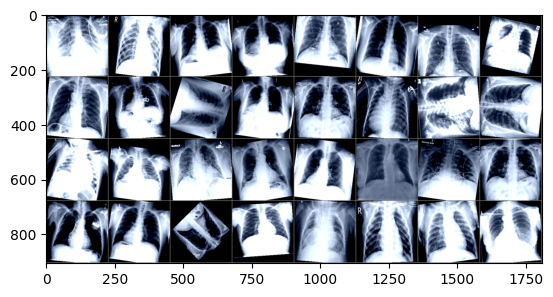

Labels: tensor([0, 2, 1, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 2, 2, 2, 1])


In [12]:
#display sample images
import matplotlib.pyplot as plt
import numpy as np
import torchvision  # Import torchvision for utils

# Helper function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('Labels:', labels)



**Define the Model**

Since I'm using DenseNet-121, we can load it with pre-trained weights from ImageNet and fine-tune it for my three-class problem (COVID, Normal, Pneumonia).

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the DenseNet-121 model with pretrained weights
model = models.densenet121(pretrained=True)

# Modify the classifier for our dataset with three classes
model.classifier = nn.Linear(model.classifier.in_features, 3)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 108MB/s]


**Set Up the Loss Function and Optimizer**

*   Loss Function: Use CrossEntropyLoss, since it’s suited for multi-class classification.
*   Optimizer: Adam or SGD can be a good choice. We’ll use Adam with a typical learning rate.



In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Training Loop**

The training loop will:

1.   Pass the images through the model.
2.   Calculate the loss and perform backpropagation.
3.   Update the model’s weights.

In [15]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training parameters
epochs = 10  # Number of epochs
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()  # Set to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)


        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and display average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}")


Epoch 1/10, Training Loss: 0.3298
Epoch 2/10, Training Loss: 0.2243
Epoch 3/10, Training Loss: 0.2140
Epoch 4/10, Training Loss: 0.2053
Epoch 5/10, Training Loss: 0.1813
Epoch 6/10, Training Loss: 0.1927
Epoch 7/10, Training Loss: 0.2003
Epoch 8/10, Training Loss: 0.1675
Epoch 9/10, Training Loss: 0.1543
Epoch 10/10, Training Loss: 0.1782


In [16]:
torch.save(model.state_dict(), "/content/densenet_covid_classification.pth")

In [17]:
# Define the path in Google Drive where you want to save the model
model_path = "/content/drive/MyDrive/densenet_covid_classification.pth"

# Save the model's state_dict to this path
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/densenet_covid_classification.pth


In [6]:
model_path = "/content/drive/MyDrive/densenet_covid_classification.pth"

In [7]:
    # Validation phase
    model.eval()  # Set to evaluation mode
    test_loss = 0.0
    correct = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get the predicted classes
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    accuracy = correct / len(test_data)
    print(f"Validation Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}")

print("Training complete!")


NameError: name 'test_loader' is not defined